# Machine Learning Calcimetry Regression

This document describes results that can be computed in this [notebook](../notebooks/regression.ipynb)

## Problem Statement

A collection of **3068** images of cores that looks like the following one is stored in a database. Each photo was preprocessed in order to define border of the core (blue and green line) and a red line is digitilized to delineate the center of the valid core. At some points a collection of calcimetry measures $\{m_i\}$ were acquired. As a first step, a thumbnail window (i.e an image $T$) is defined on the red line at each $i$ measure abscissa (blue and red rectangles).


![core](./regression_files/drill_bpe4023.png)

The question is the following **regression** question:
> Is it possible to find a predictor able to estimate the calcimetry value $m_i$ only looking at the thumbnail image

$$
m_i = f(T)
$$
where f is the regression function to be estimated.

## Our first dataset

With a thumbnail of size 128, we got **4067** valid measurement points that should be used. This defines the size of our dataset.
Each entry in the dataset is a tuple $(V_i, m_i)$


In [5]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

HOST = 'localhost'
PORT = 27010

# Load Dataset

random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    print(size)
    for i in range(10):
        idx = int(random.random()*size)
        thumb = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)
    

4067



As illustration, we draw above a collection of 10 samples randomly selected among the 4067.
In addition to the picture of the thumbnail itself, an histogram of pixel values, the calcimetry measure at 1 minute and the id of the core are also given.
* To compute the histogram, each RGB thumbnail image was first converted to a gray level image.
* As each core photo differs in resolution, the thumbnail picture was resized when extracted so that the absolute size of the 128x128 pixels is the same for all thumbnails.

In [7]:
from IPython.display import Image, HTML, display


def get_histo(img):
    gray = img.convert('L')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    img_byte_array = io.BytesIO()
    fig.savefig(img_byte_array, format='jpeg')
    plt.close(fig)
    return base64.b64encode(img_byte_array.getvalue()).decode()

def save_histo(img, filename):
    gray = img.convert('L')

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    fig.savefig(filename, format='jpeg')
    plt.close(fig)


def to_base64(img: Image):
    byte_array = io.BytesIO()
    img.save(byte_array, format='jpeg')
    return base64.b64encode(byte_array.getvalue()).decode()


html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
html_str +="<img style='width: 128px; margin: 0px; float: left; 'src='./regression_files/images_%d.jpg' />"
html_str += "<img style='width: 128px; margin: 0px; float: left; ' src='./regression_files/histo_%d.jpg' />"
html_str +="<P style='text-align: center;'>%s (%s)</P>"
html_str +="</div>\n"


all_str = " "
for i, t in enumerate(thumb_list):
    t.jpg.save(f"./regression_files/images_{i}.jpg", format="jpeg")
    save_histo(t.jpg, f"./regression_files/histo_{i}.jpg")
    all_str += html_str % (i, i, t.measurement.val_1m, t.measurement.image_id)
HTML(all_str)




## Features

To begin instead of predicting the calcimetry using directly the thumbnail pixel's matrix,  a "feature" approach was tried. 
On each thumbnail, some features are then computed (see this [notebook](../notebooks/image-quality-talk.ipynb) for more informations):
* `Focus` : The variance of the Laplacian can be a measure of the sharpness of the image, or the focus.
* `Gradient` : Magnitude of the gradient to get sharpness of edges, calculate maximum and standard deviation.
* `Colours` : The top five colours in the image from clustering analysis
* `BRISQUE` : blind/referenceless image spatial quality evaluator

As it was guess that somehow calcimetry was related with some grey level, some other features are also defined. 
* `mean_color` that is the mean of all `Colours` previously defined.
* `bin-1..5` that are 5 features build computing one 5 bins histogram on each thumbnail 

The following table summarizes all the features used in a first step once converted to pandas dataframe. To complete the dataset, the last column gives the expected calcimetry value expected to be deduced from this features.

In [58]:
import pandas as pd
import numpy as np
from calcimetry.thumbnail_api import ThumbnailAPI

n_bins = 6
def get_histo(t, n_bins):
    w, h = t.jpg.size
    histo, bins = np.histogram(t.jpg, bins=n_bins)
    return histo.astype(np.float64) / (w*h)

#create dataframe for learing
columns = [
    "focus", "mean_grad", "mean_color", "brisque"
]
for i in range(n_bins):
    columns.append(f"bin_{i}")
columns.append('target')
    
data = []

with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()    
    for idx in range(size):
        #idx = int(random.random()*size)
        t = thumb_api.read(idx)
        row = [t.quality.focus, t.quality.gradient['ave'], np.mean(t.quality.colours), t.quality.brisque]
        histo = get_histo(t, n_bins)
        for i in range(n_bins):
            row.append(histo[i])
        row.append(float(t.measurement.val_1m))
        data.append(row)
    
df = pd.DataFrame(data, columns=columns)
print(f"there are {df.count()} samples")
df.head()

there are focus         4067
mean_grad     4067
mean_color    4067
brisque       4067
bin_0         4067
bin_1         4067
bin_2         4067
bin_3         4067
bin_4         4067
bin_5         4067
target        4067
dtype: int64 samples


,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,168.300274,42.614488,93.551401,25.967468,0.008850,0.133545,0.891785,1.164612,0.733643,0.067566,29.0
1,118.353516,32.405043,89.971384,20.834656,0.032227,0.120605,0.831970,1.268433,0.739990,0.006775,31.0
2,110.426135,32.370667,85.950415,26.956238,0.040649,0.094604,0.588196,0.704224,1.201477,0.370850,33.0
3,97.795724,29.870769,77.753587,28.365417,0.039551,0.114563,0.664185,0.872192,1.042480,0.267029,33.0
4,87.493495,28.363839,68.290218,23.031433,0.050659,0.149353,0.711792,0.901733,0.977112,0.209351,33.0


###  Normalization


As our features don't use the same range, a $z_i=(x_i-\mu_i)/\sigma_i$ normalization is performed to scale each feature in $[0,1]$ range 

In [59]:
normalized_df = df.copy()
for c in columns:
    if c == 'target':
        continue
    mean = normalized_df[c].mean()
    std = normalized_df[c].std()
    normalized_df[c] = (df[c] - mean) / std 

normalized_df.head()

,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,-0.048182,0.471487,-0.397528,-0.197146,-0.604047,-0.294992,0.929507,0.557339,-0.514068,-0.576702,29.0
1,-0.300642,-0.388002,-0.519708,-0.613800,-0.394549,-0.344614,0.797319,0.763671,-0.504145,-0.730560,31.0
2,-0.340712,-0.390896,-0.656938,-0.116883,-0.319064,-0.444328,0.258585,-0.357629,0.217261,0.190889,33.0
3,-0.404553,-0.601352,-0.936684,-0.002494,-0.328910,-0.367787,0.426518,-0.023810,-0.031286,-0.071875,33.0
4,-0.456627,-0.728214,-1.259654,-0.435478,-0.229357,-0.234368,0.531729,0.034899,-0.133472,-0.217854,33.0


## Exploring the dataset

Visual exploration of the dataset is always a good way to discover information contained in data
A correlation pairplot is then displayed to have a better look which characteristics are correlated with each others. 

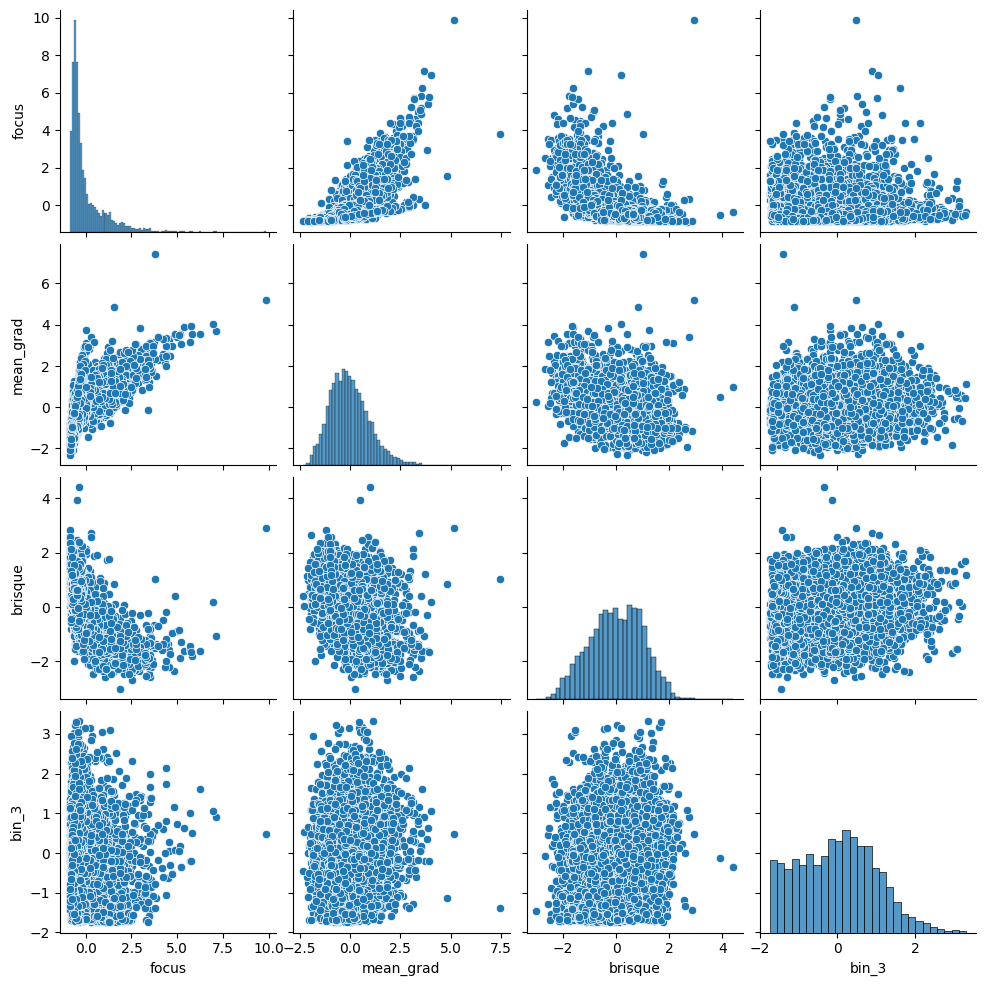

In [60]:
import seaborn as sns

# Here are selected some features to be plot.
selected_df = normalized_df[['focus', 'mean_grad', "brisque", "bin_3"]]
sns.pairplot(selected_df)

Then a correlation matrix can also be computed.

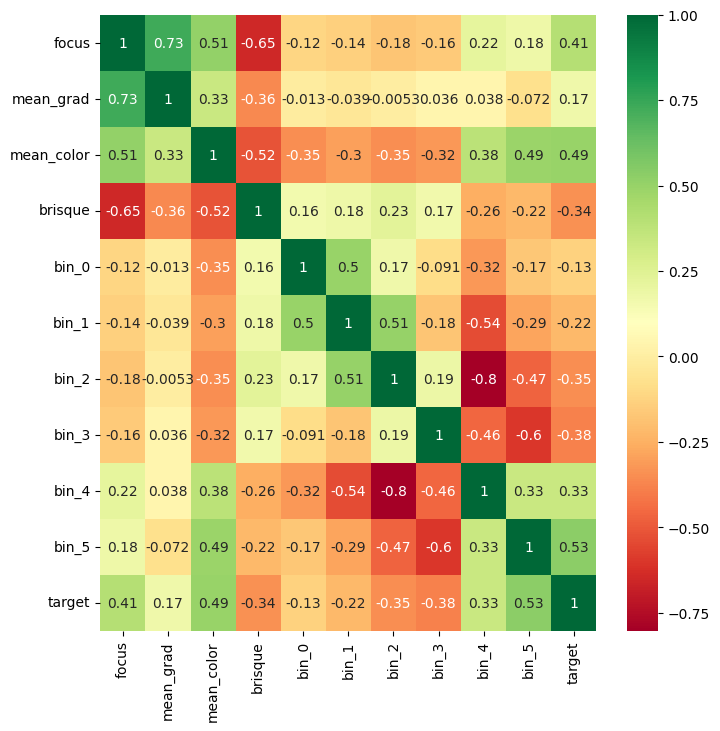

In [61]:
import seaborn as sns #visualization package
corr = normalized_df.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap= 'RdYlGn',annot=True)
plt.show()

- As it can be seen on `pairplot` some features are highly correlated as `focus` with `mean_grad`
- In this matrix, it can be seen that the `target` (calcimetry) is poorly correlated with each feature if invidualy considered.

## Performing regression

### Training 

Remember performing regression is equivalent to find $f$ (learning parameters) so that $y=f(x)$ where $y$ is our calcimetry and $x$ is a vector built using all normalized features.

In [62]:

#independent variables / explanatory variables / features
x = normalized_df.drop(labels='target', axis=1)  #axis=1 means we drop data by column.
#x = normalized_df[['mean_color']]

#dependent variable / response / target variable / calcimetry
y = normalized_df['target']

Our dataset need to be split in two :
1. A **training** dataset that will be used to estimated paramaters of our models (~80% of the dataset)
1. A **testing** dataset that will be kept to test who good is our model to predict calcimetry2) On scinde en dataset d'apprentissage et de validation

In [63]:
from sklearn.model_selection import train_test_split
#splitting the dataset into 80%-20% train-test split 
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.10,random_state=123)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(3660, 10)
(407, 10)
(3660,)
(407,)


Then regression is performed. Different models are available in the following cell from simple (`linear`) to more complicated (`extra_tree`). In this [notebook](./ExtraTreesRegressor.ipynb), python module `lazypredict` was used to benchmark many ML models.

In [82]:
from sklearn.linear_model import BayesianRidge, LinearRegression, ARDRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor     

def get_model(kind):
    return { 
        'ridge': BayesianRidge(), 
        'linear': LinearRegression(), 
        "ard": ARDRegression(),
        "mlp": MLPRegressor(max_iter=1000, solver='sgd', learning_rate="adaptive"),
        "extra_tree": ExtraTreesRegressor(n_estimators=100, random_state=123)
        }[kind]
   

lm = get_model('mlp')
lm.fit(train_x, train_y)

MLPRegressor(learning_rate='adaptive', max_iter=1000, solver='sgd')

Selected model can then be used to estimate calcimetry from features on train and test dataset and r2, q2 scores can then be computed. 

In [83]:
y_test_predicted = lm.predict(test_x)
y_train_predicted = lm.predict(train_x)

In [84]:
from sklearn import metrics as mt
print("1) The model explains,", np.round(mt.explained_variance_score(test_y,y_test_predicted)*100,2),"% variance of the target w.r.t features is")
print("2) The Mean Absolute Error of model is:", np.round(mt.mean_absolute_error(test_y,y_test_predicted ),2))
print("3) The Q-Square score of the model is " , np.round(mt.r2_score(test_y,y_test_predicted),2))
print("4) The R-Square score of the model is " , np.round(mt.r2_score(train_y,y_train_predicted),2))

1) The model explains, 49.82 % variance of the target w.r.t features is
2) The Mean Absolute Error of model is: 9.33
3) The Q-Square score of the model is  0.5
4) The R-Square score of the model is  0.57


Text(0, 0.5, 'predicted')

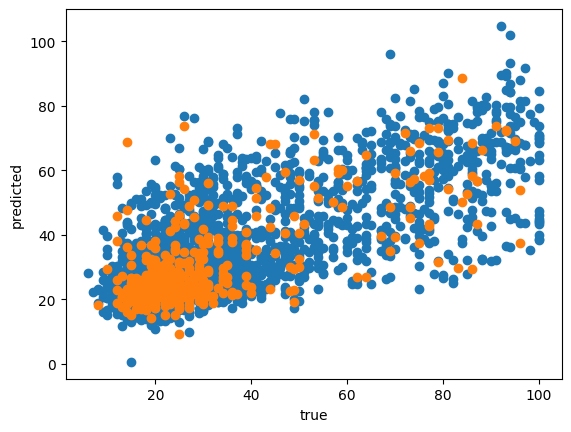

In [85]:

plt.scatter(train_y, y_train_predicted)
plt.scatter(test_y, y_test_predicted)
plt.xlabel('true')
plt.ylabel('predicted')



Cross-validated scores: [ 0.03836943  0.35735878  0.0828563  -0.89202401]
Cross-Predicted Accuracy: 0.33611321216292067


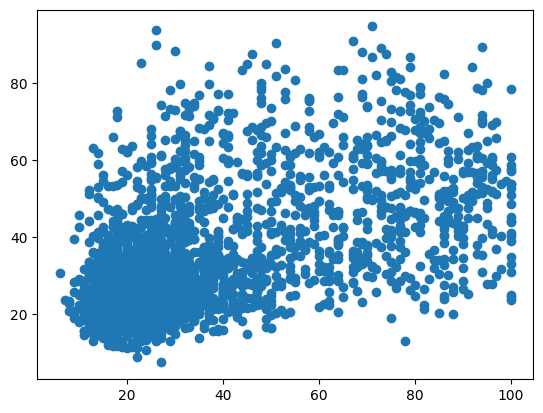

In [86]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

# Perform 4-fold cross validation
scores = cross_val_score(lm, x, y, cv=4)
print("Cross-validated scores:", scores)

# Make cross validated predictions
predictions = cross_val_predict(lm, x, y, cv=4)
plt.scatter(y, predictions)
accuracy = r2_score(y, predictions)

print("Cross-Predicted Accuracy:", accuracy)